<a href="https://colab.research.google.com/github/sauptikdhar/NTKFunctorch/blob/main/NTK_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple Experiment with Neural Tangent Kernel using Functorch**

### **Description** In this notebook we explore the functorch library for experimenting with NTKs. The main recipe for obtaining the empirical NTK adopts using the vmap and jacrev apis to to obtain the tangents. Although a simple example to obtain the NTKs is already provided in https://pytorch.org/functorch/stable/notebooks/neural_tangent_kernels.html . The example is limited to single output and does not handle other complicacies while working with NTK's. Like,
#### 1. The NTK shapes for MIMO systems.
#### 2. Comparing with the Eqv. Kernel Solution.
#### In this notebook we provide some simple helper functions and illustrate the  workings of NTK with a simple example. 

#### **Goal**:- The experiment set up is,
#### 1. We use a 3 class problem digit 3 vs 5 vs 8 using MNIST data. 
#### 2. We train a "properly" initialized (3-layer) DNN to regress on the one-hot-encoded labels.
#### 3. using the $k = \underset{k}{\text{argmax}} \; f_k(x) $ as decision rule we predict the labels.
#### We compare the performance of the DNN and the equivalent NTK for different size of hidden units.

## Import Modules

### Install Functorch (See: https://github.com/pytorch/functorch ). Note that - At the time of writing this Functorch is mainly supported for version Pytorch 1.11.

In [ ]:
!pip install functorch==0.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.4 MB 1.3 MB/s 


### **Import Modules**. Mainly we need 
#### 1. Torch, Torchvision
#### 2. Functorch
#### 3. Numpy
#### 4. Matplotlib

In [ ]:
import gc
import functorch as ft
import torch
import torchvision
import torch.nn as nn
from functorch import make_functional, vmap, jacrev
from torch.nn import Module
import torchvision.transforms as transforms
from torch.optim import SGD
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
import matplotlib.pyplot as plt
%matplotlib inline
import copy
 


device = 'cuda'    # Ofcourse Faster!

## Helper Functions

### **[Helper 1] Balanced Sampler** - used to sample uniformly for prespecified classes. This helper function is used to sample equal number of samples from each classes prespecified by user

In [ ]:
class BalancedBatchSampler(BatchSampler): 
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    # CODE SOURCE : https://discuss.pytorch.org/t/load-the-same-number-of-data-per-class/65198/4
    # LICENSE: BSD 3-Clause License (As suggested by Author use link: https://github.com/adambielski/siamese-triplet/blob/master/LICENSE 
    """
    def __init__(self, dataset, n_classes, n_samples, class_id = None, allSamples = False):
        loader = DataLoader(dataset)
        self.labels_list = []
        
        for _, label in loader:
            self.labels_list.append(label)
        
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes
        self.class_id = class_id
        self.allSamples = allSamples
 
    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            
            if self.class_id is not None:
                classes = self.class_id
            else:
                classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            
            indices = []
            for class_ in classes:
                if not self.allSamples: 
                    indices.extend(self.label_to_indices[class_][
                                   self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                        class_] + self.n_samples])
                else: 
                    indices.extend(self.label_to_indices[class_])
                
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

### **[Helper 2] Kernel Regression using NTKs (Helpers)** - Here we provide a few helper functions for 

#### a) **Computing NTK** (see https://pytorch.org/functorch/stable/notebooks/neural_tangent_kernels.html ) 



In [ ]:
def empirical_ntk(fnet_single, params, x1, x2):
    # This code is taken from functorch tutorials and is licensed as:- https://github.com/pytorch/functorch/blob/main/LICENSE
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]
    
    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]
    
    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result


b) This helper function helps to flatten the output accordingly. That is for the sample space solution $\mathbf{y} =\mathbf{K}\boldsymbol{\alpha}$ we assume $\boldsymbol{\alpha} = [\alpha_{11},\ldots,\alpha_{1L},\ldots,\alpha_{i1},\ldots,\alpha_{iL}, \ldots]$. $L =$ no. of classes, $i = 1 \ldots N$; $N$ = No. of training samples.   

$\mathbf{K}$ has to be re-shaped equivalently.

In [ ]:
def reshapeNTK(ntk):
    # This helper reshapes the Kernel for multi-valued functions. 
    ntk = ntk.permute(0,2,1,3)
    ntk = ntk.flatten(0,1)
    ntk = ntk.flatten(1,2)
    return ntk

#### c) **Kernel Regression solution.**
$$ \underset{\alpha}{\text{min}} \quad ||K(\mathbf{x_{\text{train}}}, \mathbf{x_{\text{train}}}) \alpha - \mathbf{y}_{train} ||_2^2 $$

#### Closed form solution is:-

$$ \mathbf{y}_{\text{test}} = K(\mathbf{x_{\text{test}}}, \mathbf{x_{\text{train}}}) b$$
where, 
$$b = K(\mathbf{x_{\text{train}}}, \mathbf{x_{\text{train}}})^{-1}  \mathbf{y} $$

#### **Remarks** - Here we use K - NTK kernel

In [ ]:
def predictNTK(fnet,params,Xtst, Xtrn, Ytrn = None, precomputed = False, b = None):
    
    # Compute b
    ntk_train = empirical_ntk(fnet, params, Xtrn, Xtrn)    
    ntk_train = reshapeNTK(ntk_train)     # N-D Tensor to 2D Tensor (Matrix)
    ntk_train = ntk_train.detach()
    
    if not precomputed:
        Ktr = ntk_train.cpu().numpy()
        del ntk_train
        try:
            Ktr_inv = np.linalg.solve(Ktr,np.eye(len(Ktr)))     # Kernel Inverse
        except:
            Ktr_inv = np.linalg.lstsq(Ktr,np.eye(len(Ktr)))[0]  
        
        print(Ktr_inv.shape)
        # Check the solution to tolerance
        print("Inverse Works = {}".format(np.allclose(np.dot(Ktr, Ktr_inv), np.eye(len(Ktr_inv)),atol = 1e-3)))
        b = np.dot(Ktr_inv,Ytrn)
    
    
    ntk_test = empirical_ntk(fnet, params, Xtst, Xtrn)
    ntk_test = reshapeNTK(ntk_test)
    ntk_test = ntk_test.detach()
    Ktst = ntk_test.cpu().numpy()
    del ntk_test
    Ytst = np.dot(Ktst,b)
    return (Ytst,b)

### **[Helper 3] Model Parameters** This helper function is used to get the model parameters.

In [ ]:
def gtmodelparams(model):
  W = []
  for p in model.parameters():
    wvals = p.flatten()
    wvals =  wvals.data.cpu().numpy()
    if len(W)==0:
      W = wvals
    else:
      W = np.concatenate((W,wvals),axis=None)
  return W


# **Main Experiment**

### 1. Load Data
#### For simplicity we cast a 3-class problem using the MNIST data, i.e. Digit 3 vs. Digit 5 vs. Digit 8.

#### The experiment set-up involves,
#### - No. of Training samples = 100 per class.
#### - No. of Test Samples = All test samples of digits 3, 5 and 8.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



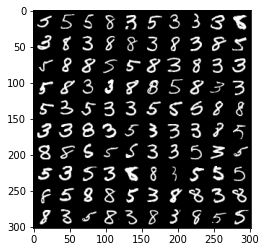

In [ ]:
# Exp Setting

class_id = [3,5,8]
n_classes = len(class_id)     

n_samples = 100
batch_size = 100

mnist_train =  torchvision.datasets.MNIST(root="./data/mnist", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
balanced_batch_sampler = BalancedBatchSampler(mnist_train, n_classes, n_samples,class_id =class_id)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_sampler=balanced_batch_sampler)

sampled_data = iter(train_loader)
images, labels = sampled_data.next()



mnist_test = torchvision.datasets.MNIST('./data/mnist',train=False,download=True,transform=torchvision.transforms.Compose([transforms.ToTensor()]))


balanced_batch_test = BalancedBatchSampler(mnist_test, n_classes, 100, class_id =class_id,allSamples = True) #n_classes, n_samples, class_id = None, allSamples = False
test_loader = torch.utils.data.DataLoader(mnist_test, batch_sampler=balanced_batch_test)


####  Us this to check the loaded data
sampled_data_test = iter(test_loader)
images_test, labels_test = sampled_data_test.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images[torch.randint(0,len(images),(100,)) ], nrow = 10))

### 2. Define the Models. Following 

Jacot et. al. ''[Neural tangent kernel: Convergence and generalization in neural networks](https://https://proceedings.neurips.cc/paper/2018/file/5a4be1fa34e62bb8a6ec6b91d2462f5a-Paper.pdf).'' NeuRIPS 2018.



We scale the weight vectors as $\frac{1}{\sqrt{n_{in}}}$ and the bias term with  $\beta = 0.1$. That is we use a custom Linear layer as,
$$ \frac{1}{\sqrt{n_{in}}} W\mathbf{x} + \beta b$$ where, $n_{in}$ is the dimension of $\mathbf{x}$.

In [ ]:

class myLinear(nn.Module): # Modified from -> https://towardsdatascience.com/how-to-build-your-own-pytorch-neural-network-layer-from-scratch-842144d623f6
    def __init__(self, in_features, out_features, bias=True, beta = 0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))
        self.bias = torch.nn.Parameter(torch.randn(out_features))
        self.beta = beta
       
        
    def forward(self, input):
        output = (input @ self.weight.t())/np.sqrt(self.in_features) + self.beta*self.bias
        return output



class DNNNTK(nn.Module): #Standard Initialization
    """
    a low precision Linear model
    """
    def __init__(self):
        super(DNNNTK, self).__init__()
        self.fc1 = myLinear(784, hidden_dim)
        self.fc2 = myLinear(hidden_dim, hidden_dim)
        self.fc3 = myLinear(hidden_dim, hidden_dim)
        self.final = myLinear(hidden_dim, n_classes)
        
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(F.relu(out))
        out = self.fc3(F.relu(out))
        out = self.final(F.relu(out))
        return out  




### Training the DL models - This is vanilla DL training using SGD! Nothing Fancy

In [ ]:
trn_acc_all = dict()
tst_acc_all = dict()
rel_W = dict()
epochs_all = dict()
tst_acc_kernel = dict() # Run Only Once

In [ ]:

hidden_dim = 200  # 10, 50, 100, 200
trn_acc_all[hidden_dim] = []
tst_acc_all[hidden_dim] = []
rel_W[hidden_dim] = []
epochs_all[hidden_dim] = []


model = DNNNTK()# Initialize Model
modelB=copy.deepcopy(model)   # Will be used later
model=model.to(device)   


W0 = gtmodelparams(model)     # Get the initialized parameters


train_loss = nn.MSELoss()     # Least Square Loss on one-hot-encoding
optimizer = SGD(model.parameters(), lr=0.5) # Basic SGD -> Contrary to popular SGD theory Authors use learning rate = 1.0. We use a smaller learning rate. 


# Load the Training data. We use Batch Size = 100 and run over 50000 iterations of SGD updates.
batch_size = 100
EPOCH = 50000   # Change as needed

sampled_data = iter(train_loader)
images, imlabels = sampled_data.next()
N = len(images)

print('Training 3 class NN model with N = {} samples'.format(N))


# Map labels for One-hot-Encoding.
# Since the class labels are class ids we map them to eqv integers [0,1,2,...]

labelMap = dict()
for (i,K) in enumerate(class_id):
    labelMap[K] = i
    



## Run the Training Iterations
for e in range(EPOCH):
    loss_epoch = 0.0
    n_batches = 0
    
    ind = torch.randint(0,N,(batch_size,))  # Emulate an SGD - stochastic
    inputs, label = images[ind],imlabels[ind]
    
    inputs=inputs.view(-1,28*28)
    label = torch.tensor([labelMap[float(K.numpy())] for K in label])
    labels = F.one_hot(label,num_classes = n_classes).float()
    
    
    
    inputs = inputs.to(device)      # in GPU
    labels = labels.to(device)      # in GPU
    
    
    # Clear gradients
    optimizer.zero_grad()

    
    # Backprop
    outputs = model(inputs)            # in GPU
    loss = train_loss(outputs,labels)
    loss.backward()
    optimizer.step()

    loss_epoch += loss.item()
    n_batches += 1

    # Collect Stats - We collect Test, Training accuracies and the relative change in weights.
    model.eval()
    
    if e%5000 == 0:
        total = 0.0
        correct = 0.0
        for tstX,tsty in test_loader:
            tstymap = torch.tensor([labelMap[float(K.numpy())] for K in tsty])
            Xtst = tstX.view(-1,28*28)
            Xtst = Xtst.to(device)     # in GPU
            ytst_out = model(Xtst)     # in GPU
            _,ytst_pred = torch.max(ytst_out.data,1)  # Multi-output  --> # in GPU
            total += tsty.size(0)
            correct += float((ytst_pred.cpu()==tstymap).sum())
        tst_acc = 100.0*(correct/total)


        # Train Accuracy
        trnymap = torch.tensor([labelMap[float(K.numpy())] for K in imlabels])
        Xtrn = images.view(-1,28*28)
        Xtrn = Xtrn.to(device)     # in GPU
        ytrn_out = model(Xtrn)     # in GPU
        _,ytrn_pred = torch.max(ytrn_out.data,1)  # Multi-output  --> # in GPU
        total = imlabels.size(0)
        correct = float((ytrn_pred.cpu()==trnymap).sum())
        tr_acc = 100.0*(correct/total)
        
        W = gtmodelparams(model)
        norm_W = np.linalg.norm(W-W0)/np.linalg.norm(W0)
      
        print("Epochs = {}, Loss(sup) = {}, Trn Acc = {}, Tst Acc. = {}, Norm W = {}".format(e,loss.item(),tr_acc,tst_acc,norm_W))
        
        trn_acc_all[hidden_dim].append(tr_acc)
        tst_acc_all[hidden_dim].append(tst_acc)
        rel_W[hidden_dim].append(norm_W)
        epochs_all[hidden_dim].append(e)



Training 3 class NN model with N = 300 samples
Epochs = 0, Loss(sup) = 0.3695853352546692, Trn Acc = 28.000000000000004, Tst Acc. = 32.26703755215577, Norm W = 0.0001152057375293225
Epochs = 5000, Loss(sup) = 0.03798897564411163, Trn Acc = 98.0, Tst Acc. = 90.33379694019472, Norm W = 0.03338835388422012
Epochs = 10000, Loss(sup) = 0.0157405287027359, Trn Acc = 100.0, Tst Acc. = 91.27260083449235, Norm W = 0.04287951812148094
Epochs = 15000, Loss(sup) = 0.009646099992096424, Trn Acc = 100.0, Tst Acc. = 91.58553546592489, Norm W = 0.04930192604660988
Epochs = 20000, Loss(sup) = 0.004804345313459635, Trn Acc = 100.0, Tst Acc. = 91.72461752433935, Norm W = 0.05360570549964905
Epochs = 25000, Loss(sup) = 0.0031690613832324743, Trn Acc = 100.0, Tst Acc. = 91.68984700973574, Norm W = 0.05645202845335007
Epochs = 30000, Loss(sup) = 0.0018274512840434909, Trn Acc = 100.0, Tst Acc. = 91.7941585535466, Norm W = 0.0583702027797699
Epochs = 35000, Loss(sup) = 0.001137229846790433, Trn Acc = 100.0, 

### Running the above cell for different dimensions we get the following Figures.

# **Equivalent  - Kernel Regression using the NTK kernel.**
### Here comes the fun part. As proved in Jacot et. al. ''[Neural tangent kernel: Convergence and generalization in neural networks](https://https://proceedings.neurips.cc/paper/2018/file/5a4be1fa34e62bb8a6ec6b91d2462f5a-Paper.pdf).'' NeuRIPS 2018.    

#### For infinite width networks the Kernel regression solution  
$$ \underset{\alpha}{\text{min}} \quad ||K(\mathbf{x_{\text{train}}}, \mathbf{x_{\text{train}}}) \alpha - \mathbf{y}_{train} ||_2^2 $$


#### yields similar solution as the DNN. The similarity (loosely the accuracy) of the Kernel solution depends on the width (no. of hiddent units) of the network.

In [ ]:
# Clean GPU Memory - Calculating the Kernel Regression (using basic Linalg routines is memory intensive)
del inputs
del labels
del outputs
del Xtst
del ytst_out
del ytst_pred
del Xtrn
del ytrn_out
del ytrn_pred


gc.collect()
torch.cuda.empty_cache()

#### Load the Training and Test Data

In [ ]:
x_train = images.view(-1,28*28)
x_train = x_train.to(device)   # in GPU
imlabels = torch.tensor([labelMap[float(K.numpy())] for K in imlabels])
y_train = F.one_hot(imlabels,num_classes = n_classes).float()
y_train= y_train.flatten()


sampled_data_test = iter(test_loader)
x_tst, y_tst = sampled_data_test.next()
x_tst = x_tst.view(-1,28*28)
x_tst = x_tst.to(device)                            #in GPU
y_tst = torch.tensor([labelMap[float(K.numpy())] for K in y_tst])



#### a. Convert the model into functional form to get the NTKs - see https://pytorch.org/functorch/stable/notebooks/neural_tangent_kernels.html

In [ ]:
model = modelB.to(device)   # Same Initialization - Be sure that we are using the correct models!
fnet, params = make_functional(model)
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

In [ ]:
del model 
gc.collect()
torch.cuda.empty_cache()

### b. Obtain the Kernel Solution. 

In [ ]:
# Training Kernel Inverse
b = []
precomputed = False

correct = 0.
total = 0.


y_tst_pred, b = predictNTK(fnet,params,x_tst, x_train, Ytrn = y_train, precomputed = precomputed, b = None)    #in GPU
y_tst_pred = y_tst_pred.reshape((-1,n_classes))
y_tst_pred_label = np.argmax(y_tst_pred,axis=1)    

correct += sum([1 if y1==y2 else 0 for y1, y2 in zip(y_tst_pred_label,y_tst) ])
total += y_tst.size(0)


tst_acc = 100.0*(correct/total)
print('The test Accuracy = {}'.format(tst_acc))

tst_acc_kernel[hidden_dim] = tst_acc

(900, 900)
Inverse Works = True
The test Accuracy = 91.30737134909597


In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Finally after running the codes for different width 10, 50 , 200 we get the following results.

### **Remarks**

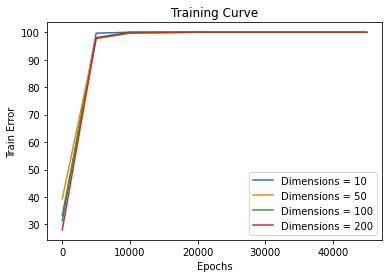

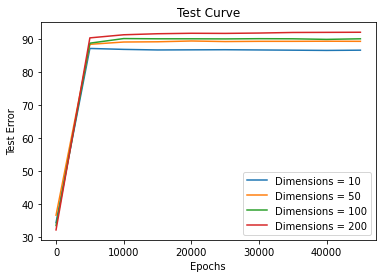

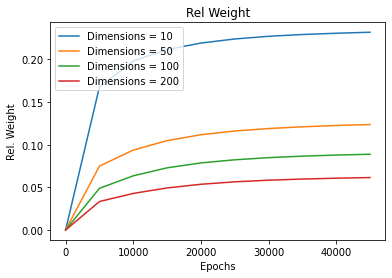

In [ ]:
import matplotlib.pyplot as plt

for hid_dim in epochs_all:
  plt.plot(epochs_all[hid_dim], trn_acc_all[hid_dim], label = "Dimensions = {}".format(hid_dim))
  
plt.legend()
plt.title('Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.show()

for hid_dim in epochs_all:
  plt.plot(epochs_all[hid_dim], tst_acc_all[hid_dim], label = "Dimensions = {}".format(hid_dim))
  
plt.legend()
plt.title('Test Curve')
plt.xlabel('Epochs')
plt.ylabel('Test Error')
plt.show()


for hid_dim in epochs_all:
  plt.plot(epochs_all[hid_dim], rel_W[hid_dim], label = "Dimensions = {}".format(hid_dim))
  
plt.legend()
plt.title('Rel Weight')
plt.xlabel('Epochs')
plt.ylabel('Rel. Weight')
plt.show()

#### As seen from the curves the relative change in weights (compared to initial weight) $\frac{||\mathbf{w}_k - \mathbf{w}_0||}{|| \mathbf{w}_0 || }$ becomes smaller as the no. of hidden units increase.

In [ ]:
print('Final Results')
print('-------------------------------------------------------------------')
print('Dimension     |       DNN                    |       NTK          ')
print('-------------------------------------------------------------------')
for hid_dim in tst_acc_kernel:
  print('{}          |     {:.2f}             |            {:.2f}'.format(hid_dim,tst_acc_all[hid_dim][-1],tst_acc_kernel[hid_dim]))
print('-------------------------------------------------------------------\n')


Final Results
-------------------------------------------------------------------
Dimension     |       DNN                    |       NTK          
-------------------------------------------------------------------
10          |     86.61             |            47.39
50          |     89.29             |            82.30
100          |     90.06             |            88.87
200          |     92.04             |            91.31
-------------------------------------------------------------------



#### This is inline to NTK theory and as such the NTK approx. for high no. of hidden units is much better. Note that for hidden_dim = 10 The NTK performance is extremely bad.

## Hence as the no. of units $\rightarrow ∞$, the DNN $\rightarrow$ NTK.(loosely).

### For further reading please see,
### 1. [Neural Tangent Kernel: Convergence and Generalization in Neural Networks](https://proceedings.neurips.cc/paper/2018/file/5a4be1fa34e62bb8a6ec6b91d2462f5a-Paper.pdf)
### 2. [Enhanced Convolutional Neural Tangent Kernels](https://arxiv.org/pdf/1911.00809.pdf)
### 3. Simple reading -> https://rajatvd.github.io/NTK/